In [1]:
import tensorflow as tf
import numpy as np
import rocket_tools as rt
from keras import backend 
from keras.backend import learning_phase
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
def train_model(model, writer_path, sess, model_path, steps=65000, batch_size=32, image_size=128, n_images=3):    
    x_input = tf.placeholder(tf.float32, 
                             [None, image_size, image_size, n_images], 
                             name='input')
    y_true = tf.placeholder(tf.float32, 
                            [None, image_size, image_size, n_images], 
                            name='mask_true')
    y_pred = model(x_input) 
    
    loss_op = -rt.losses.dice_coef(y_true, y_pred)
    adam = tf.train.AdamOptimizer()
    train_op = adam.minimize(loss_op)
    
    with tf.variable_scope('metrics'):
        tf.summary.scalar('dice', rt.losses.dice_coef(y_true, y_pred))
        tf.summary.scalar('jacard', rt.losses.jacard_coef(y_true, y_pred)) 
        tf.summary.scalar('accuracy', rt.metrics.accuracy(y_true, y_pred))
        tf.summary.scalar('IoU', rt.metrics.IoU(y_true, y_pred))
        tf.summary.scalar('log_loss', loss_op)
        tf.summary.image('input', x_input[:1, :, :, :1])
        tf.summary.image('pred', y_pred[:1, :, :, :1])
        tf.summary.image('mask', y_true[:1, :, :, :1])
        summary_op = tf.summary.merge_all()
        writer = tf.summary.FileWriter(writer_path)
    
    
    
    image_generator = rt.image_gen.ImageGenerator(image_size=(image_size, image_size))
    batch_generator = rt.batch_generator.BatchGenerator(image_generator, batch_size, 
                                                        snr_mean=5, snr_std=2, n_images=n_images)
    
    # initialize training session
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
   
    print('started training')
    for step in range(steps):
        x, y = next(batch_generator)
        _, summary = sess.run([train_op, summary_op], 
                              feed_dict={
                                  x_input: x, 
                                  y_true: y,
                                learning_phase():1
                              })
        writer.add_summary(summary, step) 
        
    print('finished training')
    saver = tf.train.Saver()
    saver.save(sess, model_path)

In [ ]:
if __name__ == "__main__":
    # parsing
    #from argparse import ArgumentParser
    #parser = ArgumentParser()

    #parser.add_argument('--snr', type=float, required=True)
    #options = parser.parse_args()
    
    tf.reset_default_graph()
      
    image_size = 128
    n_images = 3

    TB_PATH = './../tensorboard/u_net/image_size={}_snr_all_w_more_dot'.format(image_size)
    MODEL_PATH = './../saved_models/u_net_image_size={}_snr_all_w_more_dot'.format(image_size)
    os.system('rm -rf {}'.format(TB_PATH))
    
    model = rt.model.U_NET(input_=(image_size, image_size, n_images))
    sess = tf.InteractiveSession()

    train_model(model, writer_path=TB_PATH, model_path=MODEL_PATH, sess=sess)

In [2]:
model = rt.model.U_NET(input_=(128, 128, 3))
x_input = tf.placeholder(tf.float32, [None, 128, 128, 3], 
                             name='input')
y_pred = model(x_input)
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, './../saved_models/u_net_image_size=128_snr_all_w_more_dot')

INFO:tensorflow:Restoring parameters from ./../saved_models/u_net_image_size=128_snr_all_w_more_dot


In [ ]:
#x_input = tf.placeholder(tf.float32, [None, 128, 128, 3], 
                             name='input')
#y_pred = model(x_input)
#pred = y_pred.eval(feed_dict={x_input:-0.5*np.ones([1,128,128,3], dtype='float32'), learning_phase():1})

In [5]:
image_generator = rt.image_gen.ImageGenerator(image_size=(128, 128), snr_mean=2, snr_std=0)
batch_generator = rt.batch_generator.BatchGenerator(image_generator, batch_size=32, n_images=3)

x_batch, y_batch =next(batch_generator)
pred_s = sess.run(y_pred, feed_dict={x_input: x_batch, learning_phase(): 1})

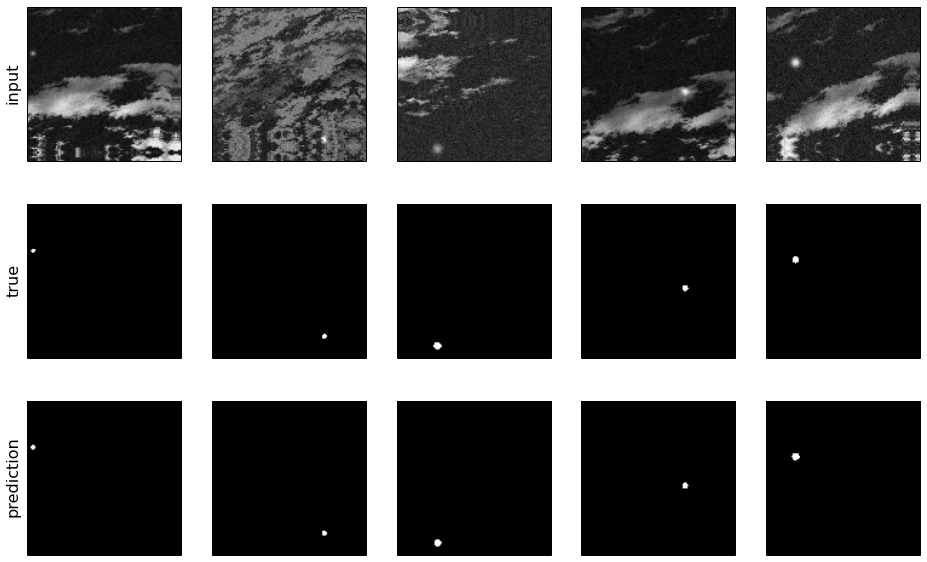

In [6]:
f, axes = plt.subplots(3, 5, figsize=(16,10))
axes[0, 0].set_ylabel('input', fontsize=16)
for i in range(5):
    ax = axes[0, i]
    ax.imshow(x_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[1, 0].set_ylabel('true', fontsize=16)
for i in range(5): 
    ax = axes[1, i]
    ax.imshow(y_batch[i][:, :, 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

axes[2, 0].set_ylabel('prediction', fontsize=16)
for i in range(5):
    ax = axes[2, i]
    ax.imshow(pred_s[i][:, :, 0], vmin=0.0, vmax=1.0, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

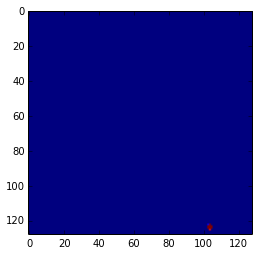

In [8]:
plt.imshow(pred_s[1][:, :, 0])